# Preprocessing Captions

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf

# Configuration (same as before)
# For your specific case (adjust as needed)
DATASET_PATH = "F:/DS/Final project 1 caption project"  # Parent folder containing everything
IMAGE_PATH = "F:/DS/Final project 1 caption project/Images"     # Folder containing all images
CAPTIONS_FILE = os.path.join(DATASET_PATH, "captions.txt")  # Captions text file
MAX_LENGTH = 40
VOCAB_SIZE = 10000
EMBEDDING_DIM = 256
LSTM_UNITS = 512
DENSE_UNITS = 512
BATCH_SIZE = 64
EPOCHS = 20

# Stage 1: Data Preparation
def prepare_data():
    print("Loading and preprocessing data...")
    
    def load_captions(filename):
        captions = {}
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                # Split on first comma only
                parts = line.split(',', 1)
                if len(parts) < 2:
                    continue
                
                img_id, caption = parts[0].strip(), parts[1].strip()
                img_id = img_id.split('.')[0]  # Remove .jpg extension
                
                if img_id not in captions:
                    captions[img_id] = []
                captions[img_id].append(caption)
        return captions
    
    captions = load_captions(CAPTIONS_FILE)
    print(f"Loaded {len(captions)} images with captions")
    
    # Save captions
    os.makedirs('preprocessed', exist_ok=True)
    with open('preprocessed/captions.pkl', 'wb') as f:
        pickle.dump(captions, f)
    
    # Preprocess captions
    def clean_caption(caption):
        caption = caption.lower()
        caption = caption.replace('[^A-Za-z]', '')  # Remove special chars
        caption = ' '.join(caption.split())         # Remove extra whitespace
        return 'startseq ' + caption + ' endseq'
    
    all_captions = []
    for img_id in captions:
        for caption in captions[img_id]:
            all_captions.append(clean_caption(caption))
    
    # Create and save tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=VOCAB_SIZE, 
        oov_token='<unk>',
        filters='!"#$%&()*+.,-/:;=?@[\\]^_`{|}~ '  # Keep apostrophes
    )
    tokenizer.fit_on_texts(all_captions)
    with open('preprocessed/tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    
    print("Data preparation complete. Files saved in 'preprocessed/' directory.")



In [ ]:
# Stage 2: Feature Extraction
def extract_features():
    print("\nExtracting image features...")
    
    # Load captions to get image IDs
    with open('preprocessed/captions.pkl', 'rb') as f:
        captions = pickle.load(f)
    
    # Create CNN model
    base_model = tf.keras.applications.InceptionV3(weights='imagenet')
    cnn_model = tf.keras.models.Model(
        base_model.input, 
        base_model.layers[-2].output
    )
    
    # Extract and save features
    features = {}
    for img_id in tqdm(captions.keys()):
        img_path = os.path.join(IMAGE_PATH, img_id + '.jpg')
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = tf.keras.applications.inception_v3.preprocess_input(img)
            feature = cnn_model.predict(img, verbose=0)
            features[img_id] = feature.reshape(2048,)
        except Exception as e:
            print(f"Error processing {img_id}: {e}")
    
    with open('preprocessed/features.pkl', 'wb') as f:
        pickle.dump(features, f)
    
    print("Feature extraction complete. Features saved to 'preprocessed/features.pkl'")



In [4]:
# Stage 3: Model Training
def train_model():
    print("\nPreparing training data and building model...")
    
    # Load preprocessed data
    with open('preprocessed/captions.pkl', 'rb') as f:
        captions = pickle.load(f)
    with open('preprocessed/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    with open('preprocessed/features.pkl', 'rb') as f:
        features = pickle.load(f)
    
    # Create sequences
    def create_sequences(tokenizer, max_length, captions, features):
        X1, X2, y = [], [], []
        for img_id, caption_list in captions.items():
            feature = features.get(img_id)
            if feature is None:
                continue
            for caption in caption_list:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = tf.keras.preprocessing.sequence.pad_sequences(
                        [in_seq], maxlen=max_length
                    )[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        return np.array(X1), np.array(X2), np.array(y)
    
    X1, X2, y = create_sequences(tokenizer, MAX_LENGTH, captions, features)
    
    # Define and train model
    def define_model(vocab_size, max_length):
        inputs1 = tf.keras.layers.Input(shape=(2048,))
        fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
        fe2 = tf.keras.layers.Dense(DENSE_UNITS, activation='relu')(fe1)
        
        inputs2 = tf.keras.layers.Input(shape=(max_length,))
        se1 = tf.keras.layers.Embedding(
            vocab_size, EMBEDDING_DIM, mask_zero=True
        )(inputs2)
        se2 = tf.keras.layers.Dropout(0.5)(se1)
        se3 = tf.keras.layers.LSTM(LSTM_UNITS)(se2)
        
        decoder1 = tf.keras.layers.Add()([fe2, se3])
        decoder2 = tf.keras.layers.Dense(DENSE_UNITS, activation='relu')(decoder1)
        outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
        
        model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer='adam'
        )
        return model
    
    model = define_model(len(tokenizer.word_index) + 1, MAX_LENGTH)
    model.summary()
    
    # Create directory for models if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'models/best_model.h5',
        monitor='loss',
        save_best_only=True,
        mode='min'
    )
    
    print("\nTraining model...")
    history = model.fit(
        [X1, X2], y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint],
        verbose=1
    )
    
    # Save training history
    with open('models/training_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    
    print("Model training complete. Saved to 'models/' directory.")



In [ ]:
'''import os
import pickle
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import re

# TensorFlow / Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Add
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Caption evaluation metrics
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider

# === Constants ===
MAX_LENGTH = 34  # Make sure this matches training time
test_image_path="F:/DS/Final project 1 caption project/Images/44856031_0d82c2c7d1.jpg"
def evaluate_and_demo():
    print("\nLoading model for evaluation and demo...")

    # Load preprocessed data
    with open('preprocessed/captions.pkl', 'rb') as f:
        captions = pickle.load(f)
    with open('preprocessed/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    with open('preprocessed/features.pkl', 'rb') as f:
        features = pickle.load(f)

    # Model architecture
    def create_model():
        inputs1 = Input(shape=(2048,))
        fe1 = Dropout(0.5)(inputs1)
        fe2 = Dense(512, activation='relu')(fe1)

        inputs2 = Input(shape=(MAX_LENGTH,))
        se1 = Embedding(len(tokenizer.word_index) + 1, 256, mask_zero=True)(inputs2)
        se2 = Dropout(0.5)(se1)
        se3 = LSTM(512)(se2)

        decoder1 = Add()([fe2, se3])
        decoder2 = Dense(512, activation='relu')(decoder1)
        outputs = Dense(len(tokenizer.word_index) + 1, activation='softmax')(decoder2)

        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
        return model

    model = create_model()
    model.load_weights('models/best_model.h5')

    def postprocess_caption(caption):
        caption = re.sub(r'\b(\w+)( \1\b)+', r'\1', caption)  # remove repeated words
        caption = caption.strip().capitalize()
        caption = re.sub(r'[ ]+', ' ', caption)
        caption = re.sub(r'[.?!,;:]*$', '', caption)
        return caption

    # Beam Search
    def generate_caption(model, tokenizer, image_features, max_length, beam_index=1, repetition_penalty=1.2):
        start = [tokenizer.word_index['startseq']]
        sequences = [[start, 0.0]]

        while len(sequences[0][0]) < min(max_length, 20):
            all_candidates = []
            for seq, score in sequences:
                padded = pad_sequences([seq], maxlen=max_length)
                preds = model.predict([image_features.reshape((1, 2048)), padded], verbose=0)[0]

                # Apply repetition penalty
                word_counts = Counter(seq)
                for word, count in word_counts.items():
                    if word < len(preds):
                        preds[word] /= (count ** repetition_penalty)

                top_preds = np.argsort(preds)[-beam_index:]

                for word in top_preds:
                    new_seq = seq + [word]
                    new_score = score + np.log(preds[word] + 1e-9)
                    all_candidates.append([new_seq, new_score])

            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_index]

        final_seq = sequences[0][0]
        final_caption = [tokenizer.index_word.get(i, '') for i in final_seq]
        final_caption = ' '.join(final_caption[1:]).split('endseq')[0].strip()
        final_caption = postprocess_caption(final_caption)
        return final_caption

    # Evaluation
    def evaluate_model(model, captions, features, tokenizer, max_length):
        actual, predicted = [], []

        for img_id in tqdm(captions.keys(), desc="Evaluating"):
            if img_id not in features:
                continue

            gen_cap = generate_caption(model, tokenizer, features[img_id], max_length, beam_index=10)
            refs = [cap.replace('startseq ', '').replace(' endseq', '').split()
                    for cap in captions[img_id]]
            actual.append(refs)
            predicted.append(gen_cap.split())

        print("\nCalculating metrics...")
        bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
        bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

        meteor_scores = [meteor_score(refs, pred) for refs, pred in zip(actual, predicted)]
        meteor = np.mean(meteor_scores)

        cider_scorer = Cider()
        references = {idx: [' '.join(ref) for ref in refs] for idx, refs in enumerate(actual)}
        hypotheses = {idx: [' '.join(pred)] for idx, pred in enumerate(predicted)}
        _, cider_scores = cider_scorer.compute_score(references, hypotheses)
        cider = np.mean(cider_scores)

        return bleu1, bleu4, meteor, cider
    # Image feature extraction for new images
    def extract_image_features(image_path):
        # Load InceptionV3 model
        cnn_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
        
        # Load and preprocess image
        img = Image.open(image_path)
        img = img.resize((299, 299))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Extract features
        features = cnn_model.predict(img_array)
        return features.reshape(1, 2048)

    eval_captions = dict(list(captions.items())[:100])
    bleu1, bleu4, meteor, cider = evaluate_model(model, eval_captions, features, tokenizer, MAX_LENGTH)

    print("\n" + "=" * 50)
    print("Evaluation Results:")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    print(f"METEOR: {meteor:.4f}")
    print(f"CIDEr:  {cider:.4f}")
    print("=" * 50 + "\n")

    # Process test image if provided
    if test_image_path:
        print(f"\nProcessing test image: {test_image_path}")
        try:
            # Load and preprocess test image
            img = Image.open(test_image_path)
            img = img.resize((299, 299))  # InceptionV3 input size
            img_array = np.array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
            
            # Extract features using same CNN as training
            cnn_model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                                        include_top=False, 
                                                        pooling='avg')
            image_features = cnn_model.predict(img_array)
            
            # Generate and print caption
            caption = generate_caption(model, tokenizer, image_features, MAX_LENGTH)
            print("\nGenerated Caption:")
            print(caption)
            
            # Display image with caption
            plt.figure(figsize=(10, 6))
            plt.imshow(Image.open(test_image_path))
            plt.axis('off')
            plt.title(f"Generated Caption:\n{caption}", pad=20)
            plt.show()
            
            return caption
            
        except Exception as e:
            print(f"Error processing test image: {str(e)}")
            return None
    else:
        print("No test image path provided. Showing evaluation metrics only.")
        return None'''

In [6]:
if __name__ == "__main__":
    # Create directories if they don't exist
    os.makedirs('preprocessed', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    # Run stages separately by uncommenting
    prepare_data()       # Stage 1
    

Loading and preprocessing data...
Loaded 8092 images with captions
Data preparation complete. Files saved in 'preprocessed/' directory.


In [8]:
if __name__ == "__main__":
    # Create directories if they don't exist
    os.makedirs('preprocessed', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    extract_features()   # Stage 2
    


Extracting image features...


  0%|          | 0/8092 [00:00<?, ?it/s]

Error processing image: [Errno 2] No such file or directory: 'F:/DS/Final project 1 caption project/Images\\image.jpg'


100%|██████████| 8092/8092 [24:53<00:00,  5.42it/s]   

Feature extraction complete. Features saved to 'preprocessed/features.pkl'


In [12]:
if __name__ == "__main__":
    # Create directories if they don't exist
    os.makedirs('preprocessed', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    train_model()        # Stage 3
    


Preparing training data and building model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 256)   │  2,175,488 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  1,574,912 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8498)      │  4,359,474 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,421,618 (35.94 MB)

 Trainable params: 9,421,618 (35.94 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 4.6011

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 1576s 254ms/step - loss: 4.6010
Epoch 2/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - loss: 3.4180

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 2668s 430ms/step - loss: 3.4180
Epoch 3/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - loss: 3.1373

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 3601s 580ms/step - loss: 3.1373
Epoch 4/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 2.9690

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 1890s 305ms/step - loss: 2.9690
Epoch 5/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 2.8644

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 2249s 362ms/step - loss: 2.8644
Epoch 6/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 2.7833

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 2228s 359ms/step - loss: 2.7833
Epoch 7/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.7318

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 8708s 1s/step - loss: 2.7318
Epoch 8/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - loss: 2.6830

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 3109s 501ms/step - loss: 2.6830
Epoch 9/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 2.6419

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 37884s 6s/step - loss: 2.6419
Epoch 10/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - loss: 2.6175

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 3187s 514ms/step - loss: 2.6175
Epoch 11/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - loss: 2.5949

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 3918s 631ms/step - loss: 2.5950
Epoch 12/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 2.5753

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 1952s 314ms/step - loss: 2.5753
Epoch 13/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 2.5586

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 2095s 338ms/step - loss: 2.5586
Epoch 14/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 2.5408

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 1981s 319ms/step - loss: 2.5408
Epoch 15/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 2.5339

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 3495s 563ms/step - loss: 2.5339
Epoch 16/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 2.5214

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 2101s 339ms/step - loss: 2.5214
Epoch 17/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.5126

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 10866s 2s/step - loss: 2.5126
Epoch 18/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - loss: 2.5080

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 2462s 397ms/step - loss: 2.5080
Epoch 19/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - loss: 2.5054

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 4555s 734ms/step - loss: 2.5054
Epoch 20/20
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 2.4913

6206/6206 ━━━━━━━━━━━━━━━━━━━━ 3327s 536ms/step - loss: 2.4913
Model training complete. Saved to 'models/' directory.


In [9]:
import os
import pickle
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import re
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

# TensorFlow / Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Add
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Caption evaluation metrics
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider

# === Constants ===
MAX_LENGTH = 34  # Make sure this matches training time
test_image_path="F:/DS/Final project 1 caption project/Images/44856031_0d82c2c7d1.jpg"
def evaluate_and_demo():
    print("\nLoading model for evaluation and demo...")

    # Load preprocessed data
    with open('preprocessed/captions.pkl', 'rb') as f:
        captions = pickle.load(f)
    with open('preprocessed/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    with open('preprocessed/features.pkl', 'rb') as f:
        features = pickle.load(f)

    def generate_blip_caption(image_path):
        try:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
            model.eval()

            # Load and preprocess image
            raw_image = Image.open(image_path).convert('RGB')
            inputs = processor(images=raw_image, return_tensors="pt").to(device)

            # Generate caption
            with torch.no_grad():
                output = model.generate(
                    **inputs,
                    max_length=30,
                    num_beams=5,
                    early_stopping=True
                )

            caption = processor.tokenizer.decode(output[0], skip_special_tokens=True)
            return caption.strip()

        except Exception as e:
            print(f"[BLIP-1 Error] {str(e)}")
            return None
        
    # Model architecture
    def create_model():
        inputs1 = Input(shape=(2048,))
        fe1 = Dropout(0.5)(inputs1)
        fe2 = Dense(512, activation='relu')(fe1)

        inputs2 = Input(shape=(MAX_LENGTH,))
        se1 = Embedding(len(tokenizer.word_index) + 1, 256, mask_zero=True)(inputs2)
        se2 = Dropout(0.5)(se1)
        se3 = LSTM(512)(se2)

        decoder1 = Add()([fe2, se3])
        decoder2 = Dense(512, activation='relu')(decoder1)
        outputs = Dense(len(tokenizer.word_index) + 1, activation='softmax')(decoder2)

        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
        return model

    model = create_model()
    model.load_weights('models/best_model.h5')

    def postprocess_caption(caption):
        caption = re.sub(r'\b(\w+)( \1\b)+', r'\1', caption)  # remove repeated words
        caption = caption.strip().capitalize()
        caption = re.sub(r'[ ]+', ' ', caption)
        caption = re.sub(r'[.?!,;:]*$', '', caption)
        return caption

    # Beam Search
    def generate_caption(model, tokenizer, image_features, max_length, beam_index=10, repetition_penalty=1.5):
        start = [tokenizer.word_index['startseq']]
        sequences = [[start, 0.0]]

        while len(sequences[0][0]) < min(max_length, 20):
            all_candidates = []
            for seq, score in sequences:
                padded = pad_sequences([seq], maxlen=max_length)
                preds = model.predict([image_features.reshape((1, 2048)), padded], verbose=0)[0]

                # Apply repetition penalty
                word_counts = Counter(seq)
                for word, count in word_counts.items():
                    if word < len(preds):
                        preds[word] /= (count ** repetition_penalty)

                top_preds = np.argsort(preds)[-beam_index:]

                for word in top_preds:
                    new_seq = seq + [word]
                    new_score = score + np.log(preds[word] + 1e-9)
                    all_candidates.append([new_seq, new_score])

            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_index]

        final_seq = sequences[0][0]
        final_caption = [tokenizer.index_word.get(i, '') for i in final_seq]
        final_caption = ' '.join(final_caption[1:]).split('endseq')[0].strip()
        final_caption = postprocess_caption(final_caption)
        return final_caption

    # Evaluation
    def evaluate_model(model, captions, features, tokenizer, max_length):
        actual, predicted = [], []

        for img_id in tqdm(captions.keys(), desc="Evaluating"):
            if img_id not in features:
                continue

            gen_cap = generate_caption(model, tokenizer, features[img_id], max_length, beam_index=10)
            refs = [cap.replace('startseq ', '').replace(' endseq', '').split()
                    for cap in captions[img_id]]
            actual.append(refs)
            predicted.append(gen_cap.split())

        print("\nCalculating metrics...")
        bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
        bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

        meteor_scores = [meteor_score(refs, pred) for refs, pred in zip(actual, predicted)]
        meteor = np.mean(meteor_scores)

        cider_scorer = Cider()
        references = {idx: [' '.join(ref) for ref in refs] for idx, refs in enumerate(actual)}
        hypotheses = {idx: [' '.join(pred)] for idx, pred in enumerate(predicted)}
        _, cider_scores = cider_scorer.compute_score(references, hypotheses)
        cider = np.mean(cider_scores)

        return bleu1, bleu4, meteor, cider
    # Image feature extraction for new images
    def extract_image_features(image_path):
        # Load InceptionV3 model
        cnn_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
        
        # Load and preprocess image
        img = Image.open(image_path)
        img = img.resize((299, 299))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Extract features
        features = cnn_model.predict(img_array)
        return features.reshape(1, 2048)

    eval_captions = dict(list(captions.items())[:100])
    bleu1, bleu4, meteor, cider = evaluate_model(model, eval_captions, features, tokenizer, MAX_LENGTH)

    print("\n" + "=" * 50)
    print("Evaluation Results:")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    print(f"METEOR: {meteor:.4f}")
    print(f"CIDEr:  {cider:.4f}")
    print("=" * 50 + "\n")

    
    # Process test image using BLIP-2
    if test_image_path:
        print(f"\nProcessing test image with BLIP-2: {test_image_path}")
        caption = generate_blip_caption(test_image_path)

        if caption:
            print("\nGenerated Caption (BLIP-2):")
            print(caption)

            # Show image with caption
            plt.figure(figsize=(10, 6))
            plt.imshow(Image.open(test_image_path))
            plt.axis('off')
            plt.title(f"Generated Caption:\n{caption}", pad=20)
            plt.show()
            return caption
        else:
            print("BLIP-2 caption generation failed.")
            return None


Loading model for evaluation and demo...


Evaluating: 100%|██████████| 100/100 [1:32:56<00:00, 55.76s/it]



Calculating metrics...

Evaluation Results:
BLEU-1: 0.3266
BLEU-4: 0.0586
METEOR: 0.2736
CIDEr:  0.0913


Processing test image with BLIP-2: F:/DS/Final project 1 caption project/Images/44856031_0d82c2c7d1.jpg

Generated Caption (BLIP-2):
a dog playing with a hose in the yard


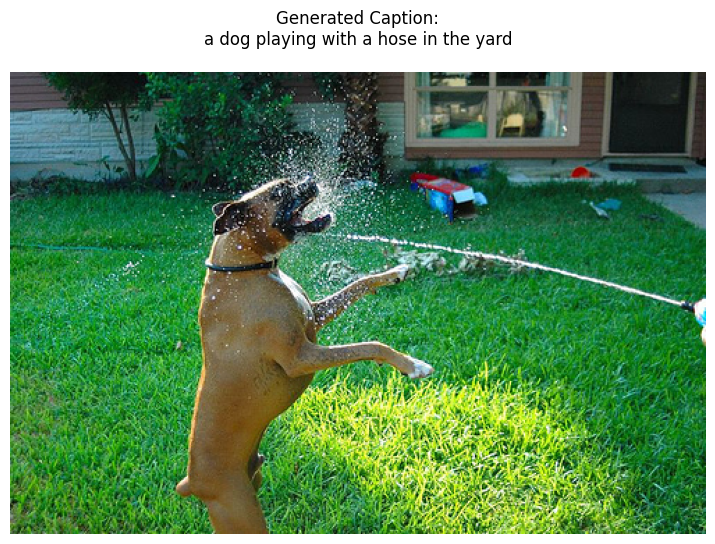

In [10]:
if __name__ == "__main__":
    # Create directories if they don't exist
    os.makedirs('preprocessed', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    evaluate_and_demo()  # Stage4